# Introduction to Transformers

Transformers have had a huge impact on the world of natural language processing (NLP) in recent times. They're a type of neural network architecture that's been changing the game since their introduction in a 2017 paper by Vaswani et al. The paper, called [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf), highlighted the power of a self-attention mechanism for handling sequential data.

Previously, when dealing with sequential data in NLP, people mostly used recurrent neural networks (RNNs). RNNs handle input data one item at a time and pass hidden state information from one time step to the next. Although they've been successful in many NLP tasks, their sequential nature limits their ability to remember long-term dependencies and makes them slow. But the transformer architecture addresses these limitations by using self-attention. This allows it to consider all the elements in a sequence simultaneously rather than processing them one by one. The self-attention mechanism is also more efficient than RNNs, making it easier to parallelize and scale.

Transformers have shown exceptional results in many NLP tasks like language translation, sentiment analysis, and text classification. They can capture long-range dependencies in the input sequence, which is especially helpful for machine translation tasks where the context of a sentence can affect its meaning. They've even been used in other sequential data tasks like image captioning and music generation. The transformer architecture is versatile and effective, which makes it a popular choice for deep learning researchers and practitioners alike.


# Base Transformer Architecture

Below is an annotated visual of the Transformer model architecture addressed in the original paper that I found from [this informational article](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html):

![image.png](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/model-min.png)

### Attention

As mentioned in the introduction, the main component that differentiates Transformers from RNNs or LSTMs is the attention mechanism. Before we dive into our encoder and decoder architectures, lets looks at how the attention mechanism is calculated. Below is the the formula for attention:

![image.png](https://raw.githubusercontent.com/ldy8665/Material/master/image/Blog/Attention_formula1.png)

Above is the basic attention formula where $K$ and $V$ are the key and value vectors, respectively, $Q$ is the query vector, and $d_k$ is the dimensionality of the key vectors. The Softmax function normalizes the scores so that they sum to one, and the dot product between $Q$ and $K$ measures the similarity between the query and each key.


### Multi-Head Attention

In transformers, we use multi-head attention to allow the model to jointly attend to information from different representation subspaces at different positions. Multi-head attention computes multiple attention weights in parallel using different linear projections of the input. The outputs of these parallel attention computations are concatenated and projected to produce the final attention output. Below is the formula for multi-head attention:

![image.png](https://www.tutorialexample.com/wp-content/uploads/2021/03/Multi-Head-Attention.png)

# Image Captioner Transformer Model Architecture

Now we will talk about the architecture we will be implementing in this model. The architecture I will be using is inspired by the architecture described in [Bornon: Bengali Image Captioning with Transformer-Based Deep Learning Approach](https://www.researchgate.net/publication/354574904_Bornon_Bengali_Image_Captioning_with_Transformer-Based_Deep_Learning_Approach). Below is an image of this architecture:

![Image](https://raw.githubusercontent.com/danplotkin/Transformer-based-Image-Captioning-From-Scratch-with-TensorFlow/main/Illustration-of-the-transformer-based-model-to-caption-image.jpg)

### The Encoder

Unlike in the original sequence-to-sequence model, before inputs are fed into the encoder, each image is ran through an image **feature extractor**, which usually consists of a pre-trained Convolutional Neural Network (CNN). These features are reshaped and fed into a fully connected layer with a ReLU activation to map the depth to the size $d_{model}$.

Our encoder block resemebles the block used in the original paper. The outputs of the ReLU activation are fed into a **global multi-head self-attention layer**. The outputs of this are added to the inputs of this layer, and the sum is normalized with a **layer normalization** layer.

The outputs of the global self-attention layer are input into a two-layer **feed forward** network with a ReLU activation in between the layers. The outputs of the network are added to the inputs of the network, and the sum is normalized with layer normalization. This output is what will be used to input into the decoder block for cross-attention which we will discuss when we talk about the decoder.

In this model we plan to stack multiple encoder blocks on top of each other. This means the outputs of the feed forward network will be passed as inputs to the next enoder block for $N$ times. The reason we do this is to allow the model to attend to different parts of the image and learn meaningful representations that can be used to generate captions.

### The Decoder

The decoder is similar to a standard Transformer decoder layout with stacked attention mechanisms. Before text is input into the decoder, it is input into an **positional embedding** layer. The layer takes as input a sequence of integer tokens, which represent words or subwords in a sentence, and returns a sequence of vectors that represent the embedding of each token and its position in the sequence. We mask all of the tokens that are padded zeros so are model can only learn tokens that represent tokens in the sequence.

The first layer of the decoder is multi-head self-attention layer with a **causal masking** mechanism that ensures the model generates the current word with only the previous word, not any future information. The inputs of the decoder and outputs of the self-attention mechanism are then added together and normalized using a layer normalization layer.

The data is then passed to a **multi-head cross-attention** to learn how to weigh the importance of each visual feature for generating the caption. In this attention mechanism, $Q$ will be the outputs of the causal self-attention layer in the decoder, and $V$ and $K$ will be the outputs of the encoder. The outputs of this layer are then added to the inputs of the layer and normalized with layer normalization.

The outputs are then passed into a feed forward neural network with the last dense layer having the same amount of units as the value of $d_{model}$. The outputs are now added to the inputs of the feed forward network and normalized with layer normalization.

In this model we plan to stack multiple decoder blocks on top of each other. This means the outputs of the feed forward network will be passed as inputs to the next decoder block for $N$ times, while using the same outputs of the encoder block for the cross-attention mechanism. The reason we do this is for our model to learn more complex relationships between the inputs and outputs, as well as prevent overfitting.


### Outputs

The outputs of the decoder are passed through a fully connected layer where the number of units are equal to the size of our vocabulary.

# Import Libraries

In [1]:
!pip install opendatasets


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: C:\msys64\mingw64\bin\python.exe -m pip install --upgrade pip


In [2]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow

[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: C:\msys64\mingw64\bin\python.exe -m pip install --upgrade pip


In [3]:
!pip install pycocoevalcap

  Using cached pycocoevalcap-1.2-py3-none-any.whl (104.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [78 lines of output]
           ---------------------------------------- 1.2/1.2 MB 4.6 MB/s eta 0:00:00
           -------------------------------------- 819.5/819.5 kB 4.0 MB/s eta 0:00:00
        Using cached wheel-0.42.0-py3-none-any.whl (65 kB)
        Using cached numpy-1.19.3.zip (7.3 MB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'error'
        error: subprocess-exited-with-error
      
        Ã— Getting requirements to build wheel did not run successfully.
        â”‚ exit code: 1
        â•°â”€> [40 lines of output]
            Traceback (most recent call last):
              File "C:\msys64\mingw64\lib\python3.9\site-packages\pip\_vendor\pep517\in_pr

In [4]:
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     -------------------------------------- 394.7/394.7 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Failed to build regex


  error: subprocess-exited-with-error
  
  × Building wheel for regex (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.mingw_x86_64-cpython-39
      creating build\lib.mingw_x86_64-cpython-39\regex
      copying regex_3\__init__.py -> build\lib.mingw_x86_64-cpython-39\regex
      copying regex_3\regex.py -> build\lib.mingw_x86_64-cpython-39\regex
      copying regex_3\_regex_core.py -> build\lib.mingw_x86_64-cpython-39\regex
      copying regex_3\test_regex.py -> build\lib.mingw_x86_64-cpython-39\regex
      running build_ext
      building 'regex._regex' extension
      error: --plat-name must be one of ('win32', 'win-amd64', 'win-arm32', 'win-arm64')
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for regex
ERROR: Could not build wheels for

In [5]:
!pip install rouge-score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     ---------------------------------------- 15.7/15.7 MB 3.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
           -------------------------------------- 132.4/132.4 kB 2.6 MB/s eta 0:00:00
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        error: subprocess-exited-with-error
      
        Ã— Building wheel for ninja (pyproject.toml) did not run successfully.
        â”‚ exit code: 1
        â•°â”€> [13 lines of output]
            C:\Users\bhavi\AppData\Local\Temp\pip-build-env-p91ce29h\overlay\lib\python3.9\site-packages\setuptools_scm\git.py:308: UserWarning: git archive did not support describe output
     

In [47]:
import os
import time
import numpy as np
import pickle
import re
import string
import matplotlib.pyplot as plt
plt.style.use('bmh')
import collections
import opendatasets as od
import pandas as pd
import csv
import ast

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

import warnings
warnings.filterwarnings('ignore')

In [7]:
od.download('https://www.kaggle.com/datasets/adityajn105/flickr8k')

Skipping, found downloaded files in ".\flickr8k" (use force=True to force download)


# Define Model Parameters

In [3]:
CAPTIONS_PATH = './flickr8k/captions.txt'
IMAGE_PATH = './flickr8k/Images/'
IMAGE_SIZE = (299, 299, 3)
NUM_LAYERS = 3
BATCH_SIZE = 32
D_MODEL = 512
NUM_HEADS = 8
EPOCHS = 50
DENSE_NODES = D_MODEL * 2
AUTOTUNE = tf.data.experimental.AUTOTUNE
MAX_SEQ_LEN = 50
VOCAB_SIZE = 10000
SOS = '<START>'
EOS = '<END>'
train_aug = tf.keras.Sequential([
    layers.RandomContrast(factor=(0.05, 0.15)),
    layers.RandomTranslation(height_factor=(-0.10, 0.10), width_factor=(-0.10, 0.10)),
	layers.RandomZoom(height_factor=(-0.10, 0.10), width_factor=(-0.10, 0.10)),
	layers.RandomRotation(factor=(-0.10, 0.10)),
    layers.RandomFlip('horizontal')
])

# Load and Map Dataset

Below we will create a function `create_mappings()` that will take our text path, delete images that have very small captions, then map our images to captions in a dictionary.

In [4]:
# function to create dictionary mapping image -> captions
def create_mappings(txt_path):
    # Load in text doc
    with open(txt_path) as f:
        next(f)
        doc = f.read()

    # create dictionary
    mapping = {}
    images_to_delete = []
    for line in doc.split('\n'):
        split = line.split(',')
        if len(split) >= 2:
            # split image with description
            image, description = split[0], split[1]
            image = os.path.join(IMAGE_PATH, image)

            # remove images with small captions
            if len(description.split()) < 5:
                images_to_delete.append(image)

            # add images into dictionary
            if image not in mapping:
                mapping[image] = []
            mapping[image].append(description)

            # delete images that had short captions
            for img in images_to_delete:
                if img in mapping:
                    del mapping[img]

    return mapping


mapping = create_mappings(CAPTIONS_PATH)

In [5]:
list(mapping.items())[:2]

[('./flickr8k/Images/1000268201_693b08cb0e.jpg',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .']),
 ('./flickr8k/Images/1001773457_577c3a7d70.jpg',
  ['A black dog and a spotted dog are fighting',
   'A black dog and a tri-colored dog playing with each other on the road .',
   'A black dog and a white dog with brown spots are staring at each other in the street .',
   'Two dogs of different breeds looking at each other on the road .',
   'Two dogs on pavement moving toward each other .'])]

In [6]:
len(mapping)

7102

# Create Training-Validaton Split

In [7]:
def train_val_mapping_split(mapping, train_size=0.8, shuffle=True):
    image_paths = list(mapping.keys())

    if shuffle:
        np.random.shuffle(image_paths)

    split = int(len(image_paths) * train_size)

    train_list = [(key, mapping[key]) for key in image_paths[:split]]
    valid_list = [(key, mapping[key]) for key in image_paths[split:]]

    return train_list, valid_list

In [8]:
# split into training and valiation sets
train_set_raw, valid_set_raw = train_val_mapping_split(mapping)

In [9]:
print(f'Training Size: {len(train_set_raw)}, Validation Size: {len(valid_set_raw)}')

Training Size: 5681, Validation Size: 1421


In [10]:
train_set_raw[0]

('./flickr8k/Images/3220140234_e072856e6c.jpg',
 ['One very fat sumo wrestler wrestles with a thinner wrestler while an umpire dressed in green watches .',
  'Two sumo wrestlers are fighting in front of a referee and two spectators .',
  'two sumo wrestlers fighting in a match',
  'Two sumo wrestlers fight in the ring as people watch .',
  'Two sumo wrestlers competing in a match .'])

# Preprocess Data

We will be preprocessing our datasets below by creating preprocessing functions and mapping it to our sets.

### Create Tokenizer

In [11]:
# get train captions into a list
train_captions = []
for row in [captions for _, captions in train_set_raw]:
    train_captions.extend(row)

# make sure we have all of the train captions
assert len(train_captions) == len(train_set_raw) * 5

In [12]:
# create custom standardization
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.strip(s)
    s = tf.strings.join([SOS, s, EOS], separator=' ')
    return s


# build vectorizer
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=MAX_SEQ_LEN,
    standardize=standardize
)

# fit on to all captions
vectorizer.adapt(train_captions)

In [13]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '<START>', '<END>', 'in', 'the', 'on', 'is', 'and']

In [14]:
vectorizer.vocabulary_size()

7394

In [15]:
seq = vectorizer('a boy is running')
seq

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([ 3,  2, 16,  8, 33,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)>

### Flatten Dataset

Right now our training and validaton sets are mapped 1:5 for images to captions. We will create a function to flatten our set to be mapped 1:1.

In [16]:
def flatten_set(input_list):
    return [(image_path, caption) for image_path, captions in input_list for caption in captions]


train_list = flatten_set(train_set_raw)
valid_list = flatten_set(valid_set_raw)

In [17]:
train_list[:3]

[('./flickr8k/Images/3220140234_e072856e6c.jpg',
  'One very fat sumo wrestler wrestles with a thinner wrestler while an umpire dressed in green watches .'),
 ('./flickr8k/Images/3220140234_e072856e6c.jpg',
  'Two sumo wrestlers are fighting in front of a referee and two spectators .'),
 ('./flickr8k/Images/3220140234_e072856e6c.jpg',
  'two sumo wrestlers fighting in a match')]

### Prepare Text

Now we will split our data into an `(inputs, labels)` format. Our inputs will consist of a tuple of `(images, input_tokens)` and our labels will be `label_tokens`. Our token shape after applying the `vectorizer` to it is `(batch_size, seq_length)`, so we will use the last dimention of our tokens to extract input and label tokens.

In [18]:
def prepare_txt(imgs, txts):
    tokens = vectorizer(txts)

    # Get valid positions
    non_zeros = tf.not_equal(tokens, 0)

    # Create padding tensor
    zeros = tf.reduce_sum(tf.cast(tf.equal(tokens, 0), tf.int64))
    zeros = tf.zeros(zeros, dtype=tf.int64)

    # Apply boolean mask and slice
    x1 = tf.boolean_mask(tokens, non_zeros)[:-1] # input seq
    x2 = tf.boolean_mask(tokens, non_zeros)[1:] # label seq

    # Concat with zeros to add padding
    input_tokens = tf.concat([x1, zeros], axis=0)
    label_tokens = tf.concat([x2, zeros], axis=0)
    return (imgs, input_tokens), label_tokens

### Prepare Images

Now we will create a function to preprocess our image paths into tensors.

In [19]:
# def prepare_imgs(img_path, data_aug=None):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, IMAGE_SIZE[:-1])

#     if data_aug is not None:
#         img = data_aug(tf.expand_dims(img, 0), training=True)
#         img = tf.squeeze(img, 0)

#     img /= 255.
#     return img
def prepare_imgs(img_path, data_aug=None):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # VGG16 input shape
    img = preprocess_input(img)
    return img

### Create and Apply Preprocessing Pipeline

Now we will combine all of these preprocessing steps into a function.

In [20]:
def apply_preprocessing_steps(flattened_list, data_aug=None):
    dataset = tf.data.experimental.from_list(flattened_list)\
        .shuffle(BATCH_SIZE * 10)\
        .map(lambda imgs, txt: (prepare_imgs(imgs, data_aug), txt))\
        .map(prepare_txt)\
        .batch(BATCH_SIZE)\
        .prefetch(AUTOTUNE)
    return dataset

In [21]:
# apply preprocessing to each of our datasets
train_ds = apply_preprocessing_steps(train_list, train_aug)
valid_ds = apply_preprocessing_steps(valid_list)

train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [22]:
print(f'Train Batches: {len(train_ds)}, Valid Batches: {len(valid_ds)}')

Train Batches: 888, Valid Batches: 223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


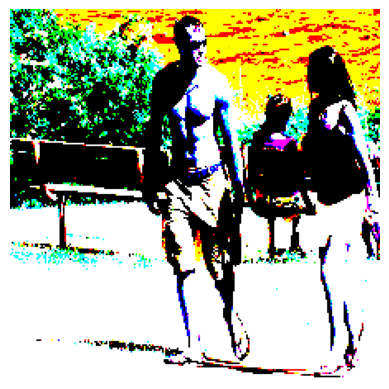

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<START> a man and a woman are walking past benches that overlook the water
a man and a woman are walking past benches that overlook the water <END>



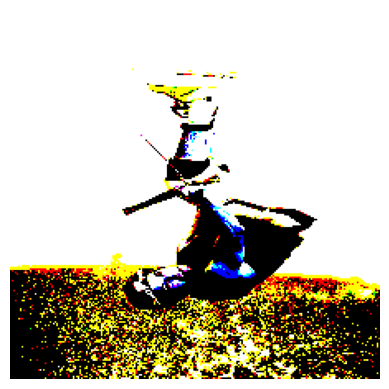

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<START> an upside down man doing a flip on a waterski board
an upside down man doing a flip on a waterski board <END>



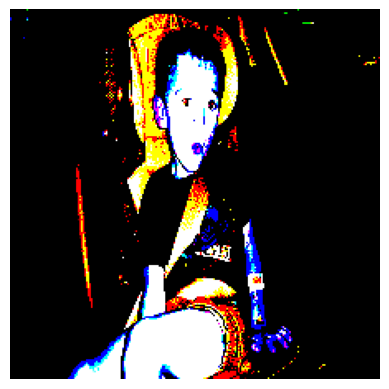

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<START> a boy sitting in a car making a surprised face
a boy sitting in a car making a surprised face <END>



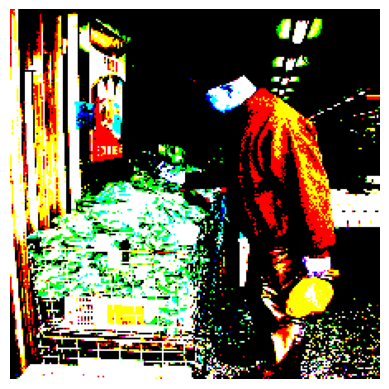

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<START> an older man examines produce
an older man examines produce <END>



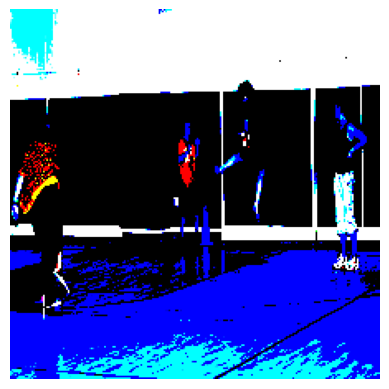

<START> a group of kids playing dodgeball
a group of kids playing dodgeball <END>



In [23]:
# validate our preprocessing
vocab = vectorizer.get_vocabulary()
for (x, y), z in train_ds.unbatch().take(5):
    in_seq = ' '.join([vocab[token] for token in y if token != 0])
    out_seq = ' '.join([vocab[token] for token in z if token != 0])
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    print(in_seq)
    print(out_seq)
    print()

# Build Model

Below we will be implementing a Transformer from scratch using Keras layers.

### Feature Extractor

Below we will create a function to build our feature extractor. We will be using the InceptionV3 pre-trained architecture.

In [24]:
def build_feature_extractor(d_model):
    # base_model = InceptionV3(include_top=False, input_shape=IMAGE_SIZE)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    base_model_output = base_model.output
    base_model_output = layers.Reshape((-1, base_model_output.shape[-1]))(base_model_output)
    base_model_output = layers.Dense(d_model, activation='relu')(base_model_output)
    cnn_model = Model(base_model.input, base_model_output, name='InceptionV3')
    return cnn_model


build_feature_extractor(D_MODEL).output.shape

TensorShape([None, 49, 512])

### Positional Embedding Layer

Below we will create our positional embedding layer to incorporate the positional information of words in each sequence. We will be using the sinusoidal encodings to find the positional encoding information with the equations below from the original paper:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model} })}$$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model} })}$$

These encodings will be summed with the word embeddings to get our positional embeddings.

In [25]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, max_length, d_model, name=None):
        super().__init__(name=name)
        self.pos_embedding = self.positional_encoding(max_length, d_model)
        self.embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=d_model,
            mask_zero=True
        )
        self.embed_scale = tf.math.sqrt(tf.cast(d_model, tf.float32))

    def call(self, inputs):
        embeddings = self.embedding(inputs) * self.embed_scale

        n_positions = tf.shape(inputs)[1]
        positions = self.pos_embedding[:, :n_positions, :]
        return positions + embeddings

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def positional_encoding(self, max_length, d_model):
        positions = np.arange(max_length)[:, np.newaxis]
        angles = self._get_angles(positions, np.arange(d_model)[np.newaxis, :], d_model)
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        pos_encoding = angles[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

Now we will view our Keras padding mask that we initialized:

In [26]:
for (_, ex_in), _ in train_ds.take(1):
  ex = ex_in[0][tf.newaxis, :]
  print(ex)
  print()
  pe = PositionalEmbedding(VOCAB_SIZE,
                           MAX_SEQ_LEN,
                           D_MODEL)(ex)
  print(pe._keras_mask)

tf.Tensor(
[[  3 312  65  34   5   2 107 175   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 49), dtype=int64)

tf.Tensor(
[[ True  True  True  True  True  True  True  True False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False]], shape=(1, 49), dtype=bool)


### Attention and Feed Forward layers

Below we will create the following layers:

1. `GlobalSelfAttention` - Attention mechanism used at the input of the encoder with no mask.

2. `CausalSelfAttention` - Attention mechanism used as the input of the decoder with a causal masking mechanism.

3. `CrossAttention` - Attention mechanism used to join and learn relationships between the decoder and encoder.

4. `FeedForward` - Feed forward network used in both the encoder and decoder.

In [27]:
class GlobalSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            dropout=dropout_rate
        )
        self.layerNorm = layers.LayerNormalization()
        self.linear_transform = layers.Dense(d_model)
        self.add = layers.Add()

    def call(self, x, training=True):
        attention_output = self.attention(
            query=x,
            key=x,
            value=x,
            training=training
        )
        selfAttentionOut = self.add([x, attention_output])
        return self.layerNorm(selfAttentionOut)


class CausalSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            dropout=dropout_rate
        )
        self.layerNorm = layers.LayerNormalization()
        self.add = layers.Add()  # use Keras add so the mask can propagate

    def call(self, x, training=True):
        attention_output = self.attention(
            query=x,
            key=x,
            value=x,
            use_causal_mask=True,
            training=training,
        )
        selfAttentionOut = self.add([x, attention_output])
        return self.layerNorm(selfAttentionOut)


class CrossAttention(layers.Layer):
    def __init__(self, d_model, num_heads, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model//num_heads,
            dropout=dropout_rate
        )
        self.layerNorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)
        self.add = layers.Add()

    def call(self, x, y, training=True):
        attention_output = self.attention(
            query=x,
            key=y,
            value=y,
            training=training
        )
        crossAttentionOut = self.add([x, attention_output])
        crossAttentionOut = self.layerNorm(crossAttentionOut)
        return crossAttentionOut


class FeedForward(layers.Layer):
    def __init__(self, dense_units, d_model, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.ff = Sequential(
            [
                layers.Dense(dense_units, activation='relu'),
                layers.Dropout(dropout_rate),
                layers.Dense(d_model),
                layers.Dropout(dropout_rate)
            ]
        )
        self.layerNorm = layers.LayerNormalization()
        self.add = layers.Add()

    def call(self, x, training=True):
        ff_output = self.ff(x, training=training)
        feedForwardOut = self.add([x, ff_output])
        return self.layerNorm(feedForwardOut)

We will validate that the Keras mask propagated through the causal self-attention layer:

In [28]:
csa_out = CausalSelfAttention(D_MODEL, NUM_HEADS)(pe)

print(ex, '\n', csa_out._keras_mask)

tf.Tensor(
[[  3 312  65  34   5   2 107 175   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 49), dtype=int64) 
 tf.Tensor(
[[ True  True  True  True  True  True  True  True False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False]], shape=(1, 49), dtype=bool)


### Encoder and Decoder Blocks

Now we will build our encoder and decoder blocks using the layers built above.

In [29]:
class EncoderBlock(layers.Layer):
    def __init__(self, dense_units, num_heads, d_model, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.self_attention = GlobalSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate
        )
        self.ff = FeedForward(
            dense_units=dense_units,
            d_model=d_model,
            dropout_rate=dropout_rate
        )

    def call(self, x, training=True):
        self_attention_out = self.self_attention(x, training=training)
        feed_forward_out = self.ff(self_attention_out, training=training)
        return feed_forward_out


class DecoderBlock(layers.Layer):
    def __init__(self, dense_units, num_heads, d_model, name=None, dropout_rate=0.1):
        super().__init__(name=name)
        self.self_attention = CausalSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate
        )
        self.cross_attention = CrossAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate
        )
        self.ff = FeedForward(
            dense_units=dense_units,
            d_model=d_model,
            dropout_rate=dropout_rate
        )

    def call(self, x, encoder_output, training=True):
        self_attention_out = self.self_attention(x, training=training)
        cross_attention_out = self.cross_attention(
            self_attention_out,
            encoder_output,
            training=training
        )
        feed_forward_out = self.ff(cross_attention_out, training=training)
        return feed_forward_out

### Implement Transformer

Below we will build our Transformer class.

In [30]:
class ImageCaptioningTransformer(Model):
    def __init__(self, num_layers, vocab_size, max_length,
                 dense_units, num_heads, d_model, dropout_rate=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.feature_extractor = build_feature_extractor(d_model)
        self.num_layers = num_layers
        self.positional_embedding = PositionalEmbedding(vocab_size,
                                                        max_length,
                                                        d_model,
                                                        name='PositionalEmbedding')
        self.encoder_layers = [
            EncoderBlock(
                dense_units, num_heads, d_model, name='EncoderBlock', dropout_rate=dropout_rate
            ) for n in range(num_layers)
        ]
        self.decoder_layers = [
            DecoderBlock(
                dense_units, num_heads, d_model, name='DecoderBlock', dropout_rate=dropout_rate
            ) for n in range(num_layers)
        ]
        self.output_layer = layers.Dense(vocab_size, name='Output')

    def call(self, inputs, training=True):
        images, text = inputs

        # extract image features
        images = self.feature_extractor(images)

        # positional encoding for decoder
        text = self.positional_embedding(text)

        # encoding stage
        for enc_layer in self.encoder_layers:
            images = enc_layer(images, training=training)

        # decoding stage
        for dec_layer in self.decoder_layers:
            text = dec_layer(text, images, training=training)

        # output
        output = self.output_layer(text)
        return output

### Initialize Model

In [31]:
model = ImageCaptioningTransformer(
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    vocab_size=vectorizer.vocabulary_size(),
    max_length=MAX_SEQ_LEN,
    dense_units=DENSE_NODES,
    d_model=D_MODEL
)

# Train Model

Below we will prepare and train our model.

### Loss and Accuracy Functions

We will create our `masked_loss` and `masked_accuracy` functions that make use of a boolean mask that is True for valid time steps and False for padded time steps.

In [32]:
def masked_loss(labels, preds):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)
    mask = (labels != 0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_acc(labels, preds):
    mask = tf.cast(labels != 0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    matches = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(matches * mask) / tf.reduce_sum(mask)
    return acc

### Learning Rate Schedule

We will create a custom learning rate schedule based on the formula used in the original paper:

$$\Large{lrate = d_{model}^{-0.5} \cdot \min(\text{step}_{\text{num}}^{-0.5}, \text{step}_{\text{num}} \cdot \text{warmup}_{\text{steps}}^{-1.5})}$$

Why do we do this? Using a fixed learning rate throughout the training process can be suboptimal. In the early stages of training, when the model parameters are far from their optimal values, a high learning rate can help the model converge more quickly. However, as training progresses and the model gets closer to the optimal parameters, a high learning rate can cause the model to overshoot the optimal values and diverge. A learning rate schedule helps address this problem by reducing the learning rate over time. We will add a scale factor to our formula so the initial learning rate is not too high.

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps, scale_factor=0.25):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.scale_factor = scale_factor

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lr = self.scale_factor * tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return lr

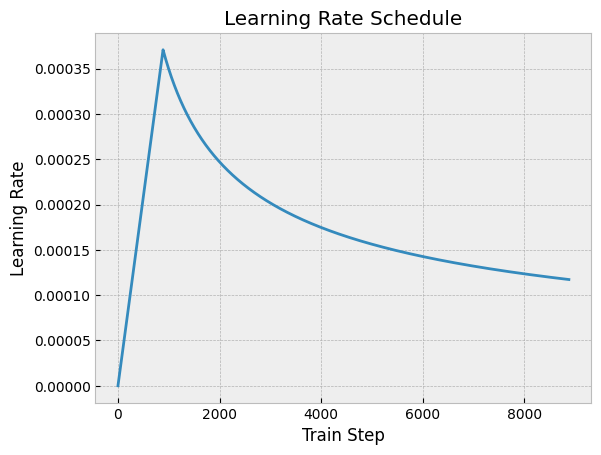

In [34]:
warmup_steps = (EPOCHS/5 * len(train_ds)) * 0.1
learning_rate = CustomSchedule(D_MODEL, warmup_steps)
optimizer = Adam(learning_rate)

plt.plot(learning_rate(tf.range(warmup_steps*10, dtype=tf.float32)))
plt.title('Learning Rate Schedule')
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

### Compile and Train Model

In [35]:
loss_fn = masked_loss
metrics = [masked_acc]
early_stopping = callbacks.EarlyStopping(patience=1, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

Now we will train our model onto our training dataset.

In [36]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50

888/888 [==============================] - 5442s 6s/step - loss: 4.4938 - masked_acc: 0.2931 - val_loss: 3.4026 - val_masked_acc: 0.3583
Epoch 2/50
888/888 [==============================] - 5629s 6s/step - loss: 3.0331 - masked_acc: 0.3966 - val_loss: 3.0791 - val_masked_acc: 0.3926
Epoch 3/50
888/888 [==============================] - 5631s 6s/step - loss: 2.6081 - masked_acc: 0.4391 - val_loss: 2.9921 - val_masked_acc: 0.4027
Epoch 4/50
888/888 [==============================] - 5969s 7s/step - loss: 2.3015 - masked_acc: 0.4769 - val_loss: 2.9926 - val_masked_acc: 0.4102


In [37]:
model.summary()

Model: "image_captioning_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InceptionV3 (Functional)    (None, 49, 512)           14977344  
                                                                 
 PositionalEmbedding (Posit  multiple                  3785728   
 ionalEmbedding)                                                 
                                                                 
 EncoderBlock (EncoderBlock  multiple                  2102784   
 )                                                               
                                                                 
 EncoderBlock (EncoderBlock  multiple                  2102784   
 )                                                               
                                                                 
 EncoderBlock (EncoderBlock  multiple                  2102784   
 )                                    

### Evaluate Training

In [38]:
_ = model.evaluate(valid_ds, steps=20)

20/20 [==============================] - 73s 4s/step - loss: 2.9716 - masked_acc: 0.3931


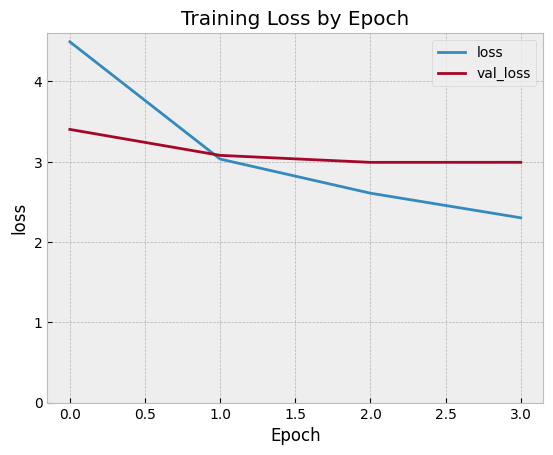

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss by Epoch')
plt.legend()
plt.show()

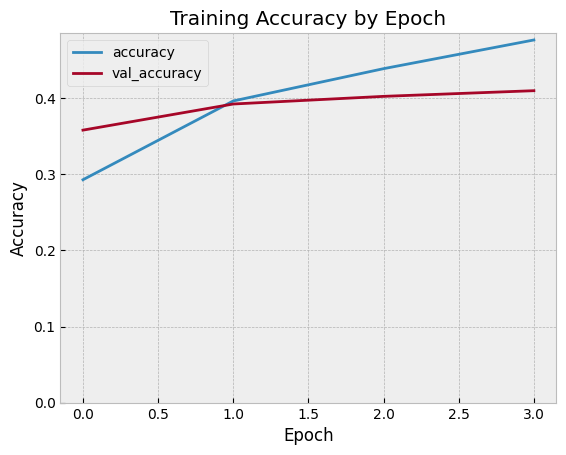

In [40]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Epoch')
plt.legend()
plt.show()

# Generate Caption

We will define the function `generate_text()` that will generate a caption when given an image path. The `temperature` parameter represents how robust and diverse our captions are. The higher the temperature, the more diverse the captions are.

In [41]:
def generate_text(img, max_length=MAX_SEQ_LEN, temperature=0):
    word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=vectorizer.get_vocabulary()
    )

    index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=vectorizer.get_vocabulary(),
        invert=True
    )

    img = prepare_imgs(img)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()
    img = tf.expand_dims(img, axis=0)
    initial = word_to_index([[SOS]])

    tokens = initial
    for n in range(max_length):
        preds = model((img, tokens), training=False).numpy()
        preds = preds[:,-1, :]
        if temperature==0:
            next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
        else:
            next = tf.random.categorical(preds/temperature, num_samples=1)
        tokens = tf.concat([tokens, next], axis=1)

        if next[0] == word_to_index(EOS):
            break
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode().capitalize()

Now we will get a random image from our validation set and generate a caption.

In [43]:
idx = np.random.randint(0, len(valid_list)-1)
print(f"Original caption: {valid_list[idx][1]}")
print(f"Generated caption: {generate_text(valid_list[idx][0])}")
print()

Original caption: A little boy made blasted something off with water .
Generated caption: A man is standing on a dock overlooking a lake



In [44]:
save_to = "VGG-16.csv"
header = ['Image', 'Caption']
images = "Images.csv"
images_pd = pd.read_csv(images)

with open(save_to, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    for index, row in images_pd.iterrows():
        image = row['Image']
        pred = generate_text(image)
        new_row = [image, pred]
        csvwriter.writerow(new_row)

In [45]:
caption = {}
df = pd.read_csv(save_to)

for index, row in df.iterrows():
    caption[row['Image']] = row['Caption']

In [50]:
MOD = 1e9 + 7
bleu1 = 0
bleu2 = 0
bleu3 = 0
bleu4 = 0
length = 1000

for index, row in images_pd.iterrows():
    true_captions = ast.literal_eval(row['Captions'])
    actual = [ele.split() for ele in true_captions]

    predicted = caption[row['Image']].split()
    b1 = sentence_bleu(actual, predicted, weights=(1,0,0,0))
    b2 = sentence_bleu(actual, predicted, weights=(0.5,0.5,0,0))
    b3 = sentence_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
    b4 = sentence_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
    bleu1 = (bleu1 + b1) % MOD
    bleu2 = (bleu2 + b2) % MOD
    bleu3 = (bleu3 + b3) % MOD
    bleu4 = (bleu4 + b4) % MOD

print(f"BLEU-1 score: {(bleu1 / length) * 100}")
print(f"BLEU-2 score: {(bleu2 / length) * 100}")
print(f"BLEU-3 score: {(bleu3 / length) * 100}")
print(f"BLEU-4 score: {(bleu4 / length) * 100}")

BLEU-1 score: 43.7036458088925
BLEU-2 score: 17.627216143340828
BLEU-3 score: 6.257216689139514
BLEU-4 score: 1.7023123039527415


In [55]:
meteor = 0

for index, row in images_pd.iterrows():
    true_captions = ast.literal_eval(row['Captions'])
    actual = [ele.split() for ele in true_captions]

    predicted = caption[row['Image']].split()
    m = meteor_score(actual, predicted)
    meteor = (meteor + m) % MOD

print(f"METEOR score: {(meteor / length) * 100}")

METEOR score: 30.204956566748137


In [53]:
# calculating rouge metric

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_precision = 0
rouge1_recall = 0
rouge1_fmeasure = 0
rouge2_precision = 0
rouge2_recall = 0
rouge2_fmeasure = 0
rougeL_precision = 0
rougeL_recall = 0
rougeL_fmeasure = 0

obj = {
    'rouge1': [0, 0, 0],
    'rouge2': [0, 0, 0],
    'rougeL': [0, 0, 0]
}

for index, row in images_pd.iterrows():
    reference_captions = ast.literal_eval(row['Captions'])
    candidate_caption = caption[row['Image']]
    # reference_captions = captions
    # candidate_caption = tokenizer.decode(t.generate(feature_extractor(Image.open(image).convert("RGB"), return_tensors="pt").pixel_values)[0])[6:-4]
    scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
    r1_p_max = 0
    r1_r_max = 0
    r1_f_max = 0
    r2_p_max = 0
    r2_r_max = 0
    r2_f_max = 0
    rL_p_max = 0
    rL_r_max = 0
    rL_f_max = 0
    for ref in reference_captions:
        temp_scores = scorer.score(ref, candidate_caption)
        r1_p_max = max(r1_p_max, temp_scores['rouge1'].precision)
        r1_r_max = max(r1_r_max, temp_scores['rouge1'].recall)
        r1_f_max = max(r1_f_max, temp_scores['rouge1'].fmeasure)

        r2_p_max = max(r2_p_max, temp_scores['rouge2'].precision)
        r2_r_max = max(r2_r_max, temp_scores['rouge2'].recall)
        r2_f_max = max(r2_f_max, temp_scores['rouge2'].fmeasure)

        rL_p_max = max(rL_p_max, temp_scores['rougeL'].precision)
        rL_r_max = max(rL_r_max, temp_scores['rougeL'].recall)
        rL_f_max = max(rL_f_max, temp_scores['rougeL'].fmeasure)
        
    obj['rouge1'][0] = (obj['rouge1'][0] + r1_p_max) % MOD
    obj['rouge1'][1] = (obj['rouge1'][1] + r1_r_max) % MOD
    obj['rouge1'][2] = (obj['rouge1'][2] + r1_f_max) % MOD
    obj['rouge2'][0] = (obj['rouge2'][0] + r2_p_max) % MOD
    obj['rouge2'][1] = (obj['rouge2'][1] + r2_r_max) % MOD
    obj['rouge2'][2] = (obj['rouge2'][2] + r2_f_max) % MOD
    obj['rougeL'][0] = (obj['rougeL'][0] + rL_p_max) % MOD
    obj['rougeL'][1] = (obj['rougeL'][1] + rL_r_max) % MOD
    obj['rougeL'][2] = (obj['rougeL'][2] + rL_f_max) % MOD

print(f'Rouge1: Precision = {obj["rouge1"][0] * 100 / length}, Recall = {obj["rouge1"][1] * 100 / length}, f_measure = {obj["rouge1"][2] * 100 / length}')
print(f'Rouge2: Precision = {obj["rouge2"][0] * 100 / length}, Recall = {obj["rouge2"][1] * 100 / length}, f_measure = {obj["rouge2"][2] * 100 / length}')
print(f'RougeL: Precision = {obj["rougeL"][0] * 100 / length}, Recall = {obj["rougeL"][1] * 100 / length}, f_measure = {obj["rougeL"][2] * 100 / length}')

Rouge1: Precision = 38.61933656172665, Recall = 43.505876818287966, f_measure = 38.31244295434887
Rouge2: Precision = 14.70227987770173, Recall = 17.149021549915513, f_measure = 14.906624387192183
RougeL: Precision = 36.262118474792736, Recall = 41.70904987083777, f_measure = 36.28156169159895


In [51]:
predictions_file = "VGG-Transformer.csv"
reference_file = "Test-Images.csv"
header = ["Image", "Caption"]

ref_df = pd.read_csv(reference_file)

with open(predictions_file, 'w', newline = "") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    for index, row in ref_df.iterrows():
        image = row["Image"].replace("/input", "")
        generated_caption = generate_text(image)
        csvwriter.writerow([image, generated_caption])